In [1]:
import os
import sys
import time
import logging
import multiprocessing
import pandas as pd
import numpy as np
from tqdm import tqdm

# Set up logging
logging.basicConfig(
    filename="hdf5_processing_log.txt",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

def process_and_save_hdf5(file_path):
    """Processes and modifies an HDF5 file in-place."""
    try:
        start_time = time.time()
        logging.info(f"Processing {file_path}")
        print(file_path)

        name=os.path.basename(file_path)
        num,_=name.split('.')
        with pd.HDFStore(file_path, mode='a') as store:  # 'a' mode allows modifying the file
            if 'hits' not in store or 'records' not in store:
                logging.error(f"Skipping {file_path}: Missing 'hits' or 'records' dataset.")
                return f"Skipped {file_path}: Missing required datasets."

            logging.info('Successfull loading')
            # Read datasets
            hits = store['hits']
            records = store['records']

            if 'event_no' in hits.columns:
                hits = hits.drop(columns=['event_no'])
            if 'event_no' in records.columns:
                records = records.drop(columns=['event_no'])

            # Compute event bins per record_id (Optimized)
            hits["min_time"] = hits.groupby("record_id")["time"].transform('min')
            hits["event_no"] = np.floor((hits["time"] - hits["min_time"]) // 100 + 1).astype(np.int64)
            hits["event_no"] += ( hits["record_id"].astype(np.int64) * 10**6  # Ensures uniqueness within a dataset
                                    + np.int64(num) * 10**12 ) # Adds uniqueness across datasets)

            hits.drop(columns=["min_time"], inplace=True)

            # Generate event truth mapping (Corrected Aggregation)
            event_truth = hits[['record_id', 'event_no', 'type']].drop_duplicates()
            event_truth = event_truth.groupby('event_no', as_index=False).agg({'record_id': 'min', 'type': 'min'})

            # Drop 'type' column before merging
            #records.drop(columns=['type'], errors='ignore', inplace=True)
            #hits.drop(columns=['type'], errors='ignore', inplace=True)

            # Merge on event_no (Corrected)
            merged_df = records.merge(event_truth, on='record_id', how='left', sort=False)
            return hits,merged_df
            logging.info('hit the save part of the function')
            # ✅ Overwrite modified datasets inside the same HDF5 file
            store.put('hits', hits, format='table', data_columns=True)
            store.put('records', merged_df, format='table', data_columns=True)

        duration = time.time() - start_time
        logging.info(f"Completed {file_path} in {duration:.2f} seconds")
        return f"Processed {file_path} in {duration:.2f} seconds"

    except Exception as e:
        logging.error(f"Error processing {file_path}: {str(e)}")
        return f"Error processing {file_path}: {str(e)}"

def update_progress_bar(total_files, progress_queue):
    """Updates the progress bar based on completed tasks."""
    with tqdm(total=total_files, desc="Processing HDF5 Files") as pbar:
        for _ in range(total_files):
            progress_queue.get()  # Wait for an update
            pbar.update(1)

def process_files_parallel(files, num_workers=8):
    """Processes multiple HDF5 files in parallel using multiprocessing."""
    manager = multiprocessing.Manager()
    progress_queue = manager.Queue()
    total_files = len(files)

    # Start progress bar in a separate process
    progress_process = multiprocessing.Process(target=update_progress_bar, args=(total_files, progress_queue))
    progress_process.start()

    def update_progress(_):
        """Callback function to update progress bar after each process."""
        progress_queue.put(1)

    with multiprocessing.Pool(processes=num_workers) as pool:
        for file_path in files:
            pool.apply_async(process_and_save_hdf5, args=(file_path,), callback=update_progress)

        pool.close()
        pool.join()

    progress_process.join()
    print("Processing complete!")



In [2]:
hits,records=process_and_save_hdf5('../data/634.h5')

../data/634.h5


In [12]:
import matplotlib.pyplot as plt
def plot(hits):
    """
    Generate and display a histogram plot of 'time' for different 'type' values 
    within a specific 'record_id' in the given DataFrame.
    """
    # Select the first unique record_id
    record = hits['record_id'].unique()[0]
    
    # Get all unique types
    types = hits['type'].unique()
    
    # Filter hits for the selected record_id
    hit = hits[hits['record_id'] == record]
    mid=hit[hit['type']!=2]['event_no'].value_counts().median()
    var=np.std(hit[hit['type']!=2]['event_no'].value_counts())
    #print(mid,var)
    
    # Create a figure
    fig, ax = plt.subplots(figsize=(8, 5))
    
    interval = np.arange(hit['time'].min(), hit['time'].max(), 100)

    # Iterate through each unique type and plot its histogram

    y, x = np.histogram(hit[hit['type'] != 2]['time'], bins=interval)
    x = (x[:-1] + x[1:]) / 2  # Convert bin edges to bin centers
    ax.plot(x, y+1, label=f'Type: Noise')
        
    y, x = np.histogram(hit['time'], bins=interval)
    x = (x[:-1] + x[1:]) / 2  # Convert bin edges to bin centers
    ax.plot(x, y+1, label=f'Type : All')
    
    for i in range(1,6):
        ax.plot(x,((i*var)+mid)*np.ones(x.shape[0]),label=f'{i} x var')
    
    # Labeling and legend
    ax.set_xlabel("Time")
    ax.set_ylabel("Frequency")
    ax.set_title(f"Histogram for Record ID {record}")
    ax.legend()

    # Show the plot each time the function is called
    plt.ylim(bottom=500)
    plt.yscale('log')
    plt.show()

# Example usage:
#plot(hits)  # This will display the plot each time the function is called


In [13]:
for record in hits['record_id'].unique():
    hit=hits[hits['record_id']==record]
    filtered_hit=hit[~hit['type'].isin([0,1,2])]
    counts=filtered_hit['event_no'].value_counts()
    threshold=(5*counts.std())+counts.median()
    total_counts=hit['event_no'].value_counts()
    excess_events=total_counts[total_counts>threshold].index
    hit_filtered = hit[~hit['event_no'].isin(excess_events)]
    if record==19:
        break

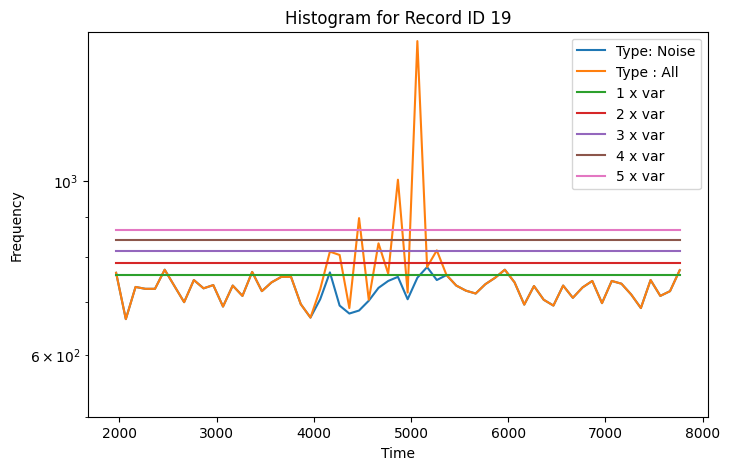

In [14]:
plot(hit)

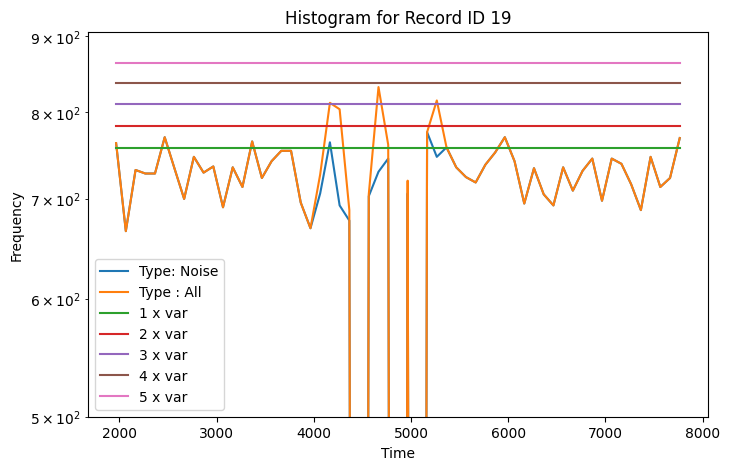

In [15]:
plot(hit_filtered)

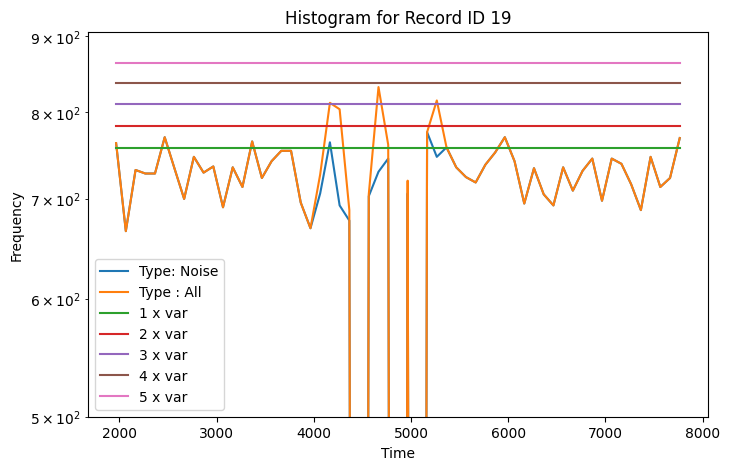

In [17]:
plot(hit_filtered)

In [495]:
import pandas as pd
import numpy as np
t=time.time()
# Step 1: Remove unwanted types (0, 1, 2) in one operation
valid_hits = hits.loc[~hits["type"].isin([0, 1, 2])]

# Step 2: Count occurrences of each (record_id, event_no)
event_counts = valid_hits.groupby(["record_id", "event_no"]).size()

# Step 3: Compute threshold per record_id using transform (avoids separate .groupby() calls)
std_dev = event_counts.groupby(level=0).transform('std')
median = event_counts.groupby(level=0).transform('median')
threshold = (5 * std_dev) + median

#step3.5: get total count 
total_count = hits.groupby(["record_id", "event_no"]).size()

# Step 4: Filter out overpopulated (record_id, event_no) pairs
excess_events = total_count[total_count > threshold].index

# Step 5: Remove these from the original hits DataFrame in a single operation
hits_filtered = hits.set_index(["record_id", "event_no"], drop=False)
hits_filtered.drop(index=excess_events, errors="ignore", inplace=True)
hits_filtered.reset_index(drop=True, inplace=True)
print(time.time()-t)

3.6587657928466797


In [494]:
import pandas as pd
import numpy as np
t=time.time()
# Step 1: Remove unwanted types in one operation
valid_hits = hits.loc[~hits["type"].isin([0, 1, 2])]

# Step 2: Count occurrences of each (record_id, event_no)
event_counts = valid_hits.groupby(["record_id", "event_no"]).size()

# Step 3: Compute std and median in a single groupby().agg() operation
stats = event_counts.groupby(level=0).agg(['std', 'median'])
stats.fillna(0, inplace=True)  # Handle cases where std() might be NaN due to single values

# Compute threshold directly using NumPy
thresholds = (5 * stats["std"]) + stats["median"]

# Step 3.5: Get total count
total_count = hits.groupby(["record_id", "event_no"]).size()

# Step 4: Identify overpopulated (record_id, event_no) pairs
excess_events = total_count[total_count > thresholds.reindex(total_count.index, level=0)].index

# Step 5: Remove them using .loc[] instead of set/reset index
hits_filtered = hits.loc[~hits.set_index(["record_id", "event_no"]).index.isin(excess_events)]

# Reset index for final output
hits_filtered.reset_index(drop=True, inplace=True)
print(time.time()-t)

2.892303943634033


In [497]:
import pandas as pd
import numpy as np
t=time.time()

# Step 1: Filter out unwanted types (vectorized operation, avoids .isin())
valid_mask = ~hits["type"].isin([0, 1, 2])
valid_hits = hits[valid_mask]

# Step 2: Compute event counts using NumPy
group_keys = ["record_id", "event_no"]
event_counts = valid_hits.groupby(group_keys, sort=False).size()

# Step 3: Compute std and median efficiently
record_grouped = event_counts.groupby(level=0, sort=False)
std_values = record_grouped.std(ddof=0)  # ddof=0 for population std (faster)
median_values = record_grouped.median()

# Compute threshold using NumPy (broadcasting for speed)
thresholds = (5 * std_values) + median_values

# Step 3.5: Get total count for all events
total_count = hits.groupby(group_keys, sort=False).size()

# Step 4: Find overpopulated event pairs (vectorized threshold comparison)
excess_events_mask = total_count.values > thresholds.reindex(total_count.index, level=0).values
excess_events_idx = total_count.index[excess_events_mask]

# Step 5: Directly filter hits using NumPy indexing (fastest method)
hits_filtered = hits[~hits.set_index(group_keys).index.isin(excess_events_idx)].reset_index(drop=True)
print(time.time()-t)

2.6374828815460205


In [500]:
import pandas as pd
import numpy as np
import time

t = time.time()

# Step 1: Remove unwanted types (faster than `.isin()`)
valid_hits = hits.loc[hits["type"].values > 2]  

# Step 2: Compute event counts **without Pandas groupby()**
group_keys = ["record_id", "event_no"]
rec_event_array = valid_hits[group_keys].to_numpy()  # Convert to NumPy for speed
unique_pairs, event_counts = np.unique(rec_event_array, axis=0, return_counts=True)

# Convert to a DataFrame for easy lookup
event_counts_df = pd.DataFrame(unique_pairs, columns=group_keys)
event_counts_df["count"] = event_counts

# Step 3: Compute std and median using NumPy (significantly faster)
record_groups = event_counts_df.groupby("record_id")["count"]
std_values = record_groups.std(ddof=0).fillna(0).to_dict()  # Convert to dict for O(1) lookup
median_values = record_groups.median().to_dict()

# Compute threshold using NumPy
event_counts_df["threshold"] = (5 * event_counts_df["record_id"].map(std_values)) + event_counts_df["record_id"].map(median_values)

# Step 3.5: Get total count **without Pandas groupby()**
rec_event_array_all = hits[group_keys].to_numpy()
unique_pairs_all, total_count = np.unique(rec_event_array_all, axis=0, return_counts=True)

# Convert total counts to a DataFrame
total_counts_df = pd.DataFrame(unique_pairs_all, columns=group_keys)
total_counts_df["count"] = total_count

# Step 4: Identify excess events
excess_mask = total_counts_df["count"] > total_counts_df["record_id"].map(std_values) * 5 + total_counts_df["record_id"].map(median_values)
excess_events = total_counts_df.loc[excess_mask, group_keys].apply(tuple, axis=1).values  # Convert to tuple format for fast lookup

# Step 5: Fast filtering using NumPy indexing
record_event_pairs = hits[group_keys].apply(tuple, axis=1).values
mask_to_keep = ~np.isin(record_event_pairs, excess_events)

# Apply the mask
hits_filtered = hits.loc[mask_to_keep].reset_index(drop=True)

print("Time taken:", time.time() - t)


Time taken: 25.841578483581543


In [ ]:
import pandas as pd
import numpy as np
import time

t = time.time()

# Step 1: Remove unwanted types (already optimized)
valid_hits = hits.loc[hits["type"] > 2]  

# Step 2: Compute event counts (already optimized)
group_keys = ["record_id", "event_no"]
event_counts = valid_hits.groupby(group_keys, sort=False).size()

# Step 3: Compute std and median (already optimized)
record_grouped = event_counts.groupby(level=0, sort=False)
std_values = record_grouped.std(ddof=0).fillna(0)  
median_values = record_grouped.median()
thresholds = (5 * std_values) + median_values

# Step 3.5: Get total count (already optimized)
total_count = hits.groupby(group_keys, sort=False).size()

# Step 4: Identify excess events (already optimized)
excess_events = set(total_count.loc[total_count > thresholds.loc[total_count.index]].index)  # Convert to set for fast lookup

# Step 5: Optimized Filtering (FAST!)
# Convert each row into a tuple (avoiding `set_index()`)
record_event_tuples = list(zip(hits["record_id"], hits["event_no"]))

# Fast NumPy boolean mask
mask_to_keep = ~np.isin(record_event_tuples, list(excess_events))

# Apply the mask
hits_filtered = hits.loc[mask_to_keep].reset_index(drop=True)

print("Time taken:", time.time() - t)


In [505]:
import pandas as pd
import numpy as np
import time

t = time.time()

# Step 1: Remove unwanted types (already optimized)
valid_hits = hits.loc[hits["type"] > 2]  

# Step 2: Compute event counts (already optimized)
group_keys = ["record_id", "event_no"]
event_counts = valid_hits.groupby(group_keys, sort=False).size()

# Step 3: Compute std and median (already optimized)
record_grouped = event_counts.groupby(level=0, sort=False)
std_values = record_grouped.std(ddof=0).fillna(0)  
median_values = record_grouped.median()
thresholds = (5 * std_values) + median_values  # Index is "record_id"

# Step 3.5: Get total count (already optimized)
total_count = hits.groupby(group_keys, sort=False).size()

# Step 4: Identify excess events (Now Fixed!)
aligned_thresholds = thresholds.reindex(total_count.index, level=0)  # Align indices
excess_events = set(total_count.loc[total_count > aligned_thresholds].index)  # Now correctly indexed

# Step 5: Optimized Filtering (FAST!)
record_event_tuples = list(zip(hits["record_id"], hits["event_no"]))

# Fast NumPy boolean mask
mask_to_keep = ~np.isin(record_event_tuples, list(excess_events))

# Apply the mask
hits_filtered = hits.loc[mask_to_keep].reset_index(drop=True)

print("Time taken:", time.time() - t)


Time taken: 1.550797939300537


In [16]:
import pandas as pd
import numpy as np
import time

t = time.time()

# Step 1: Remove unwanted types (already optimized)
valid_hits = hits.loc[hits["type"] > 2]  

# Step 2: Compute event counts (already optimized)
group_keys = ["record_id", "event_no"]
event_counts = valid_hits.groupby(group_keys, sort=False).size()

# Step 3: Compute std and median (already optimized)
record_grouped = event_counts.groupby(level=0, sort=False)
std_values = record_grouped.std(ddof=0).fillna(0)  
median_values = record_grouped.median()
thresholds = (5 * std_values) + median_values  

# Step 3.5: Get total count (already optimized)
total_count = hits.groupby(group_keys, sort=False).size()

# Step 4: Identify excess events (Optimized)
aligned_thresholds = thresholds.reindex(total_count.index, level=0)
excess_events = total_count.index[total_count > aligned_thresholds]

# Convert to dictionary (O(1) lookups instead of `isin()`)
excess_events_dict = {key: True for key in excess_events}

# Step 5: Optimized Filtering (Fast Dictionary Lookup!)
record_event_tuples = list(zip(hits["record_id"], hits["event_no"]))  # This was actually FASTER
mask_to_keep = np.array([key not in excess_events_dict for key in record_event_tuples], dtype=bool)

# Apply the mask
hits_filtered = hits.loc[mask_to_keep].reset_index(drop=True)

print("Time taken:", time.time() - t)


Time taken: 0.9895613193511963


In [19]:
import shutil

In [20]:
shutil.copy2

<function shutil.copy2(src, dst, *, follow_symlinks=True)>

In [27]:
os.path.dirname('/raven/ptmp/arego/LBC_Chunk/hits_chunk/')

'/raven/ptmp/arego/LBC_Chunk/hits_chunk'

In [67]:
original_file_path='/raven/ptmp/arego/LBC/100000s/0.h5'

In [37]:
from pathlib import Path

# Given path (replace this with your actual path)
path = Path('/raven/ptmp/arego/LBC/100000s/0.h5')

# Go up two levels
path = path.parents[1]

In [49]:
output_dir= os.path.dirname(path)
temp_dir=''
i=1
while os.path.isdir(temp_dir):
    temp_dir=f'{output_dir}_{i}'
    i+=1
output_dir=temp_dir

1

In [60]:
import os

# Assuming 'path' is defined and points to a valid directory
output_dir = os.path.dirname(path)
temp_dir = output_dir  # Start with the original output_dir
i = 1

# Check if output_dir already exists
while os.path.isdir(temp_dir)  and os.path.isfile(path):
    # Create a new temp_dir with an incremented suffix
    temp_dir = f'{output_dir}_{i}'
    i += 1

# Final output_dir is the new unique directory
output_dir = temp_dir

print(f"The unique output directory is: {output_dir}")


The unique output directory is: /raven/ptmp/arego/LBC/100000s


In [58]:
os.path.isdir(os.path.dirname(path)) and os.path.isfile(path)

False

In [68]:
output_dir = os.path.dirname(original_file_path)
temp_dir = output_dir  # Start with the original output_dir
i = 1
name=os.path.basename(original_file_path)
# Check if output_dir already exists
while os.path.isdir(temp_dir) and os.path.isfile(f'{temp_dir}/{name}'):
    # Create a new temp_dir with an incremented suffix
    temp_dir = f'{output_dir}_{i}'
    i += 1

# Final output_dir is the new unique directory
output_dir = temp_dir

In [69]:
output_dir

'/raven/ptmp/arego/LBC/100000s_1'